# Credit Card Fraud Detection
<ul>
    <li>I - Introduction</li>
    <li>II - Exploring the datas</li>
</ul>

## I - Introduction

### Context
<p style="text-align:justify;">It is important that credit card companies are able to recognize fraudulent credit card transactions so that customers are not charged for items that they did not purchase.</p>

### Content
<p style="text-align:justify;">The datasets contains transactions made by credit cards in September 2013 by european cardholders. This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.</p>

<p style="text-align:justify;">It contains only numerical input variables which are the result of a PCA transformation. Unfortunately, due to confidentiality issues, we cannot provide the original features and more background information about the data. Features V1, V2, ... V28 are the principal components obtained with PCA, the only features which have not been transformed with PCA are 'Time' and 'Amount'. Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset. The feature 'Amount' is the transaction Amount, this feature can be used for example-dependant cost-senstive learning. Feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise.</p>

### Inspiration
Identify fraudulent credit card transactions.

<p style="text-align:justify;">Given the class imbalance ratio, we recommend measuring the accuracy using the Area Under the Precision-Recall Curve (AUPRC). Confusion matrix accuracy is not meaningful for unbalanced classification.</p>

### Acknowledgements
<p style="text-align:justify;">The dataset has been collected and analysed during a research collaboration of Worldline and the Machine Learning Group (http://mlg.ulb.ac.be) of ULB (Université Libre de Bruxelles) on big data mining and fraud detection. More details on current and past projects on related topics are available on http://mlg.ulb.ac.be/BruFence and http://mlg.ulb.ac.be/ARTML</p>

<p style="text-align:justify;">Please cite: Andrea Dal Pozzolo, Olivier Caelen, Reid A. Johnson and Gianluca Bontempi. Calibrating Probability with Undersampling for Unbalanced Classification. In Symposium on Computational Intelligence and Data Mining (CIDM), IEEE, 2015</p>

## II - Exploring the datas
Let's take a look at the datas to make decisions on what type model we should use.
### 1. Importing the datas

In [38]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.gridspec as gridspec
import random
import scipy.stats as st
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import numpy as np
import math
from time import time

from scipy.interpolate import griddata
import matplotlib.pyplot as plt
import numpy.ma as ma
from numpy.random import uniform, seed
from matplotlib import cm

In [39]:
datas = pd.read_csv("../../too_big_datas/credit_card/creditcard.csv")

In [40]:
display(datas.head())
print("The shape of the datas is {}".format(datas.shape))

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


The shape of the datas is (284807, 31)


### 2. How to evaluate performances
If we built a classifier which always flag the data as not a fraud, we would have the following performances:

In [41]:
print("Accuracy: {:.4f}%".format((datas.Class==0).sum()/len(datas)*100))

Accuracy: 99.8273%


### 2. Quick data overview
<ul>
    <li><b>Time:</b> Number of seconds elapsed between the first transaction and this transaction.</li>
    <li><p style="text-align:justify;"><b>V1-28:</b> Input variables after PCA transformation. (PCA = Mathematic transformation that cannot be reversed to orthogonalize datas. Its role here is to provide security by respecting the privacy of the cardholders. As it is a dimensional reduction it also means that there is loss is the data informations.)</p></li>
    <li><b>Amount:</b> The amount of the transaction.</li>
    <li><b>Class:</b> It is the label of the datas. 1 = case of fraud, 0 = otherwise.</li>
</ul>
<p style="text-align:justify;">This dataset contains transactions that occured in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.</p>

### 3. How to choose a type of algorithm?

In [42]:
counts = pd.value_counts(datas["Class"], ascending=True)
print("The number of Fraudulent transactions is: {}".format(counts[1]))
print("The number of Normal transactions is: {}".format(counts[0]))
print("The ratio is: {:.3f}%".format(counts[1]/counts[0]*100))

The number of Fraudulent transactions is: 492
The number of Normal transactions is: 284315
The ratio is: 0.173%


<p style="text-align:justify;">In this case we have a lot of negative examples (normal transaction) compare to the number of positive examples (fraudulent transaction). So what should we choose? First question: Unsupervised or Supervised learning algorithm?</p>

<p style="text-align:justify;">In this case I would tend to use an unsupervised learning algorithm. Here is why: When you have a comparable number of positive and negative examples the algorithm can learn the characteristics of the anomalies easily. Thus we should use a classic classification algorithm => Supervised learning. But when we have a lot more informations of what a normal example looks like, we should learn what a positive example is instead. After the algorithm finish learning it can detect when an example is "not normal".</p>

This technics uses Gaussian Distribution.
### 4. Crash course on Gaussian Distribution
<p style="text-align:justify;">The idea behind this algorithm is that if we choose the measured features widely we can see it in a graph when there is an anomaly. For example if you were building to verify if an engine does not have any anomaly, you might mesure heat and vibrations while it is testing. Then if you plot this datas, an abnormal engine will have its point far from the other engines which are normal.</p>


<img style="float:left;" height="500" width="500" src="anomaly_detection.png"/>
<img style="float:left;" height="450" width="450" src="anomaly_detection2.png"/>

<p style="float:left;text-align:justify;">We determine the gaussian model that best fits the datas for the negative examples (image on the right). The center of this graph is where the gaussian is higher. This is where the chances for an example are higher. The farer we get from the center the less probable it is for an example to be normal.</p>

### 5. Anomaly detection using normal distribution

To perform anomaly detection using gaussian distribution there are three steps to follow:

<b>First step</b>

<p style="text-align:justify;">We need to choose the different features $x_{i}$. This features needs to be helpfull in determining weither the example is an anomaly or not.</p>

<b>Second step</b>

<p style="text-align:justify;">We need to fit the different parameters of the gaussians. If we have m examples we need to fit $\mu_{1}$, ..., $\mu_{m}$, $\sigma_{1}^{2}$, ..., $\sigma_{m}^{2}$. We can do so using these two formulas: </p>

$\mu_{j}=\frac{1}{m} \sum_{i=1}^{m}x_{j}^{(i)}$

$\sigma_{j}^{2}=\frac{1}{m} \sum_{i=1}^{m}(x_{j}^{(i)}-\mu_{j})^{2}$


<b>Third step</b>

<p style="text-align:justify;">Now that we have trained our algorithm, we can make predictions on a new example x, using the following formula:</p>

$p(x)=\prod_{j=1}^{n}p(x_{j};\mu_{j},\sigma_{j}^{2})=\prod_{j=1}^{n}\frac{1}{\sqrt{2\pi}\sigma_{j}}exp\left(-\frac{\left (x_{j}-\mu_{j}\right)^{2}}{2\sigma_{j}^{2}}\right )$

There is an anomaly when $p(x) < \epsilon$

<p style="text-align:justify;">The formula with the exponential is just the formula for the gaussian distribution. We obtain this multiplication because we suppose that all the datas are independant. This is the case for the project we are studying but it is generally not a big deal.</p>

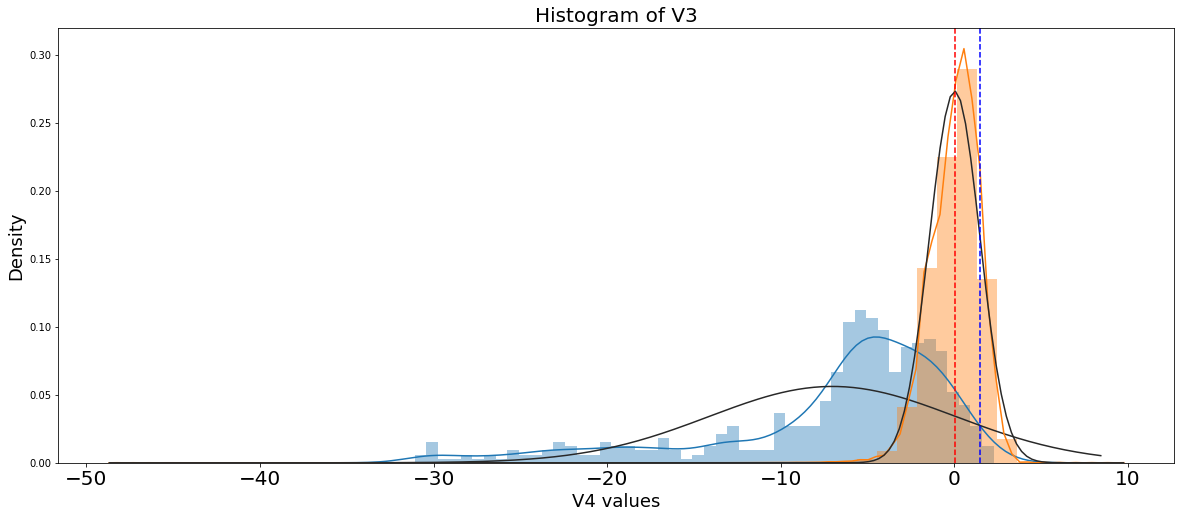

In [43]:
fig = plt.figure(figsize=(20,8))

sns.distplot(datas["V3"][datas.Class == 1], bins=50, fit=st.norm)
sns.distplot(datas["V3"][datas.Class == 0], bins=50, fit=st.norm)

plt.axvline(datas["V3"][datas.Class == 0].mean(), color='r', linestyle='--')
plt.axvline(np.sqrt(datas["V3"][datas.Class == 0].var()), color='b', linestyle='--')
plt.title("Histogram of V3", size=20)
plt.xlabel("V4 values", size=18)
plt.ylabel("Density", size=18)
plt.xticks(size=20)

plt.show()

We can clearly see here that the distribution of the data is not exactly Gaussian. But the Gaussian curve is still a good approximation. And if we get a value of 5 for this feature, it is very likely that it is a fraud.

In [44]:
#/!\ C'est la version finale qui fonctionne /!\

def gauss2(X, mu, Sigma2):
    k = len(mu)
    Sigma2 = np.diag(Sigma2)
    p = np.prod(np.exp(sum(-np.power((X - mu), 2) * np.linalg.pinv(Sigma2)) * 0.5))
    return p

In [45]:
gauss2(np.array([1, 1]), np.array([1, 1]), np.array([1,1]))

1.0

### 6. Splitting the dataset
<p style="text-align:justify;">For this algorithm, we need to separate positive examples from negative examples. But we also need to determine the threshold: $\epsilon$. To do so, we need to make a Cross-Validation dataset. So we need three datasets:<ul>
    <li>Training dataset: 60% of good dataset</li>
    <li>Cross-Validation dataset: 20% of good dataset / 50% of anomalous dataset</li>
    <li>Test dataset:  20% of good dataset / 50% of anomalous dataset</li>
</ul>
</p>

In [46]:
#scaler = MinMaxScaler()
#datas[datas.columns.drop("Class")] = scaler.fit_transform(datas[datas.columns.drop("Class")])

#We split the normal/fraud datasets
fraud_datas = datas[datas.Class==1]
normal_datas = datas[datas.Class==0]

print("Fraud datas: {}".format(fraud_datas.shape))
print("Normal datas: {}".format(normal_datas.shape))

train_normal, validate_normal, test_normal = np.split(normal_datas, [int(len(normal_datas)*.6), int(len(normal_datas)*.8)])
validate_fraud, test_fraud = np.split(fraud_datas, 2)

train_datas = train_normal
valid_datas = pd.concat([validate_fraud, validate_normal])
test_datas = pd.concat([test_normal, test_fraud])

print()
print("datas: \tshape: \t\tnbr_fraud \tnbr_normal")
print("Train \t{} \t{} \t\t{}".format(train_datas.shape, len(train_datas[train_datas.Class==1]), len(train_datas[train_datas.Class==0])))
print("CV \t{} \t{} \t\t{}".format(valid_datas.shape, len(valid_datas[valid_datas.Class==1]), len(valid_datas[valid_datas.Class==0])))
print("Test \t{} \t{} \t\t{}".format(test_datas.shape, len(test_datas[test_datas.Class==1]), len(test_datas[test_datas.Class==0])))

Fraud datas: (492, 31)
Normal datas: (284315, 31)

datas: 	shape: 		nbr_fraud 	nbr_normal
Train 	(170589, 31) 	0 		170589
CV 	(57109, 31) 	246 		56863
Test 	(57109, 31) 	246 		56863


### 7. Fitting the parameters

In [47]:
train_datas.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


#### Using numpy

In [48]:
train_datas.drop(["Time", "Amount"], axis=1, inplace=True)

In [49]:
train_datas = train_datas[:2000]

In [50]:
y_train = train_datas.Class
X_train = train_datas.drop(["Class"], axis=1)

mu = np.mean(X_train.values, axis=0)
sigma = np.var(X_train.values, axis=0)

In [51]:
X_train.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153


#### Using TensorFlow

### 8. Visualizing the datas

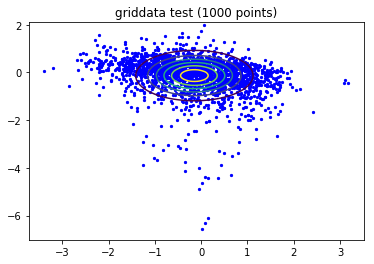

In [52]:
from scipy.interpolate import griddata
import matplotlib.pyplot as plt
import numpy.ma as ma
from numpy.random import uniform, seed
from matplotlib import cm
def gauss(x,y,Sigma,mu):
    X=np.vstack((x,y)).T
    mat_multi=np.dot((X-mu[None,...]).dot(np.linalg.inv(Sigma)),(X-mu[None,...]).T)
    return  np.diag(np.exp(-1*(mat_multi)))


def plot_countour(x,y,z):
    # define grid.
    xi = np.linspace(-2.1, 2.1, 100)
    yi = np.linspace(-2.1, 2.1, 100)
    ## grid the data.
    zi = griddata((x, y), z, (xi[None,:], yi[:,None]), method='cubic')
    levels = [0.001, 0.01, 0.1, 1]
    # contour the gridded data, plotting dots at the randomly spaced data points.
    #CS = plt.contour(xi,yi,zi,len(levels),linewidths=0.5,colors='k', levels=levels)
    #CS = plt.contourf(xi,yi,zi,15,cmap=plt.cm.jet)
    #CS = plt.contourf(xi,yi,zi,len(levels),cmap=cm.Greys_r, levels=levels)
    # plt.colorbar() # draw colorbar
    # plot data points.
    
    plt.scatter(train_datas["V13"], train_datas["V14"], marker='o', c='b', s=5)    
    plt.contour(xi,yi,zi)
    #plt.xlim(-2, 2)
    #plt.ylim(-2, 2)
    plt.title('griddata test (%d points)' % npts)
    plt.show()


# make up some randomly distributed data
seed(1234)
npts = 1000
x = uniform(-2, 2, npts)
y = uniform( -2, 2, npts)
z = gauss(x, y, Sigma=np.asarray(np.diag([sigma[12], sigma[13]])), mu=np.asarray([mu[12],mu[13]]))

plot_countour(x, y, z)

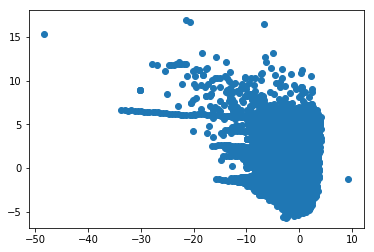

In [53]:
plt.scatter(datas["V3"], datas["V4"])
plt.show()

In [54]:
gauss(0, 0, Sigma=np.asarray(np.diag([1, 1])), mu=np.asarray([1,1]))

array([0.13533528])

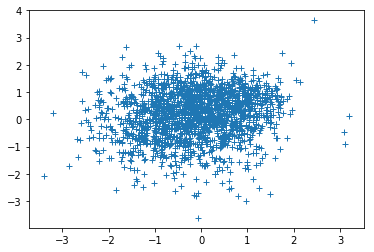

-0.13091241011493607
0.5870398173332567
-0.1044827745486954
0.6138296551379503


In [55]:
plt.plot(train_datas["V13"], train_datas["V15"], "+")

x = np.linspace(0, 1, 50)
y = np.linspace(0, 1, 50)
xv, yv = np.meshgrid(x, y)

plt.show()
print(mu[13])
print(sigma[13])
print(mu[15])
print(sigma[15])

### 8. Prediction

In [56]:
len(valid_datas)

57109

In [59]:
def predict(X):
    pred = 1
    #for index in X.index:
        #print(index)
    for k in range(len(X)):
        pred *= gauss2(X[k], [mu[k]], [sigma[k]])
        #print(gauss2(X[k], [mu[k]], [sigma[k]]))
    return pred

In [60]:
probabilities = []
count = 0
for k in valid_datas.index:
    X = valid_datas.loc[k]
    probabilities.append(predict(X.drop(["Time", "Amount", "Class"])))
    count+=1
    if count % 1000 == 0:
        print(count)

1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000


In [ ]:
valid_datas.loc[173054]

In [ ]:
predict(valid_datas.loc[173054].drop(["Time", "Amount", "Class"]))

In [ ]:
test = pd.concat([valid_datas, prob], axis=1)
tet = (test[test.Class==0][0] == 0)
for k in tet.index:
    if(tet[k]):
        print(k)

In [84]:
prob = pd.Series(probabilities)
prob.index = valid_datas.index

# prob < epsilon ==> Fraude [True == Fraud]
epsilon = (prob.max() + prob.min())/2

start = prob.min()
stop = prob.max()

maxEps = prob.min()
maxF1 = 0.0001

F1_history = []

count = 0
for epsilon in np.linspace(1e-200, 1e-20, 10):
    fp = pd.concat([prob < epsilon, valid_datas.Class == 0], axis=1).all(axis=1).sum()
    tp = pd.concat([prob < epsilon, valid_datas.Class == 1], axis=1).all(axis=1).sum()
    fn = pd.concat([prob >= epsilon, valid_datas.Class == 1], axis=1).all(axis=1).sum()

    prec = tp/(tp+fp)
    rec = tp/(tp+fn)

    F1 = 2*prec*rec/(prec + rec)
    F1_history.append(F1)
    
    if F1 > maxF1:
        maxF1 = F1
        maxEps = epsilon
    print(fp)
    
    count +=1 
    if count % 100 == 0:
        print(count)
#print(maxEps)
#print(maxF1)

191
2626
2677
2706
2726
2746
2757
2766
2775
2783


In [55]:
pd.concat([valid_datas.Class, prob], axis=1)[0].head()

541      4.441898e-21
623      3.320165e-10
4920     4.165815e-26
6108    1.002660e-139
6329     1.387066e-55
Name: 0, dtype: float64

In [316]:
epsilonMax = 2.1588715105504715e-15
F1Max = 0.019740259740259742

In [403]:
prob.min()

0.0

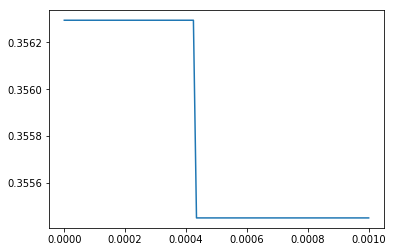

In [84]:
plt.plot(np.linspace(0, 0.001, 100), F1_history)
plt.show()

In [369]:
np.linspace(start, stop, 10000)

array([0.00000000e+00, 2.15887151e-15, 4.31774302e-15, ...,
       2.15822385e-11, 2.15843974e-11, 2.15865562e-11])

In [317]:
prob = pd.Series(probabilities)
prob.index = valid_datas.index

# prob < epsilon ==> Fraude [True == Fraud]
fp = pd.concat([prob < epsilonMax, valid_datas.Class == 0], axis=1).all(axis=1).sum()
tp = pd.concat([prob < epsilonMax, valid_datas.Class == 1], axis=1).all(axis=1).sum()
fn = pd.concat([prob >= epsilonMax, valid_datas.Class == 1], axis=1).all(axis=1).sum()

prec = tp/(tp+fp)
rec = tp/(tp+fn)

F1 = 2*prec*rec/(prec + rec)

if F1 > maxF1:
    maxF1 = F1
    maxEps = epsilon

count +=1 
if count % 100 == 0:
    print(count)

In [331]:
test = valid_datas.Class==1

accuracy = 0

print("Cas de merde: {}".format((len(valid_datas)-test.sum())/len(valid_datas)))
print("Mon cas: {}".format())

ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

In [355]:
test1 = pd.Series([0,0.25,0.5,0.75,1])
test2 = pd.Series([1,1,0, 0,0])

display(pd.concat([test1, test2], axis=1))

eps = 0.8

pd.concat([test1 >= eps, test2 == 1], axis=1)

,0,1
0,0.00,1
1,0.25,1
2,0.50,0
3,0.75,0
4,1.00,0


,0,1
0,False,True
1,False,True
2,False,False
3,False,False
4,True,False


## III - Examining the features

In [68]:
v_features = datas.ix[:,1:29].columns

C:\Users\roland\AppData\Roaming\Python\Python36\site-packages\ipykernel_launcher.py:1: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  """Entry point for launching an IPython kernel.


For this algorithm to work well, we need to choose/pre-process the features as follow:
<ul>
    <li>It needs to have a (semi) gaussian distribution</li>
    <li>p(x) needs to be large for normal and small for fraud.</li>
    <li>It is preferable that the feature has very large or very small values for anomalies.</li>
</ul>

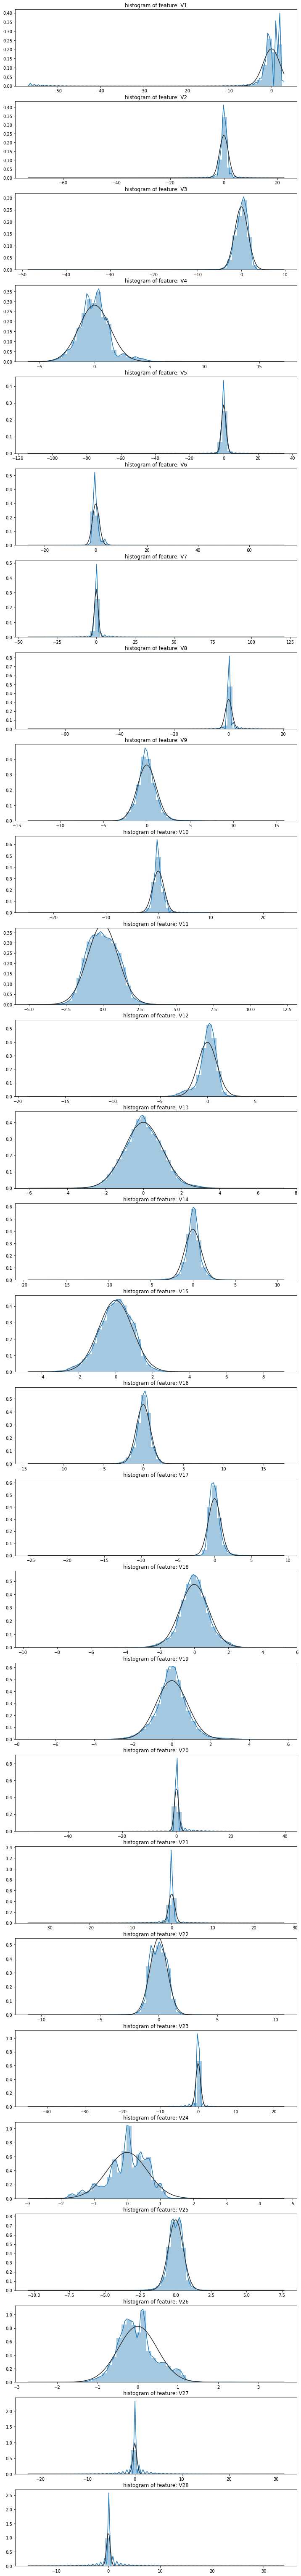

In [69]:
plt.figure(figsize=(12,28*4))
gs = gridspec.GridSpec(28, 1)
for i, cn in enumerate(datas[v_features]):
    ax = plt.subplot(gs[i])
    sns.distplot(datas[cn], fit=st.norm, bins=50)
    ax.set_xlabel('')
    ax.set_title("histogram of feature: " +str(cn))
plt.show()

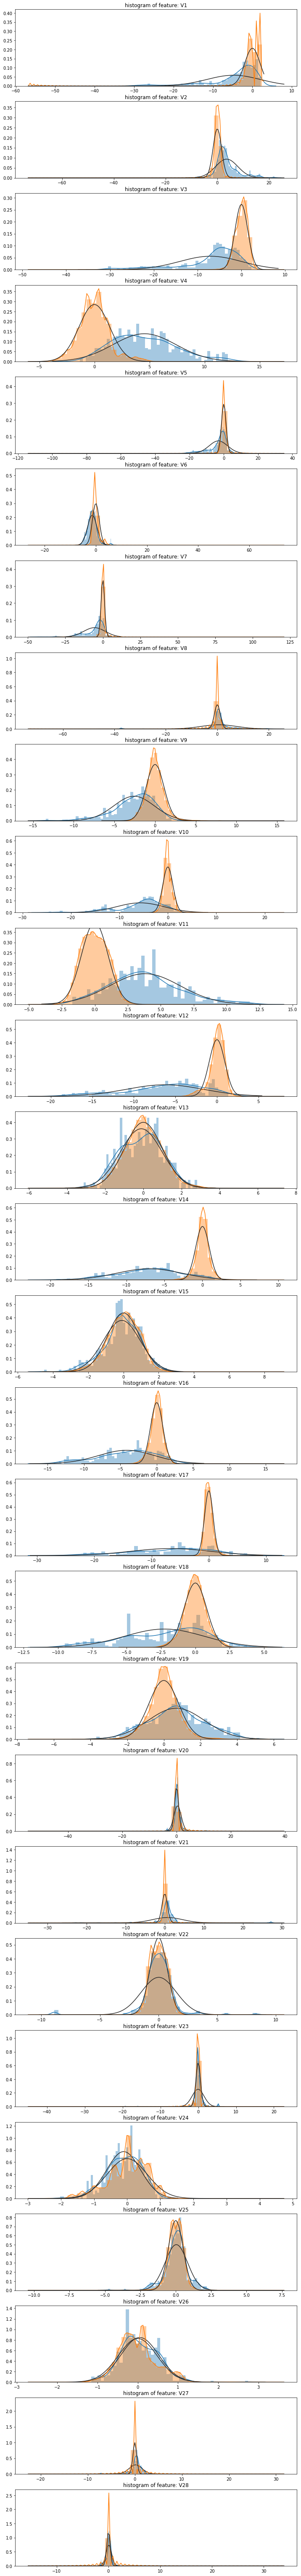

In [70]:
plt.figure(figsize=(12,28*4))
gs = gridspec.GridSpec(28, 1)
for i, cn in enumerate(datas[v_features]):
    ax = plt.subplot(gs[i])
    sns.distplot(datas[cn][datas.Class == 1], bins=50, fit=st.norm)
    sns.distplot(datas[cn][datas.Class == 0], bins=50, fit=st.norm)
    ax.set_xlabel('')
    ax.set_title('histogram of feature: ' + str(cn))
plt.show()

In [71]:
indexes = datas.columns[1:3]
print(indexes)

Index(['V1', 'V2'], dtype='object')


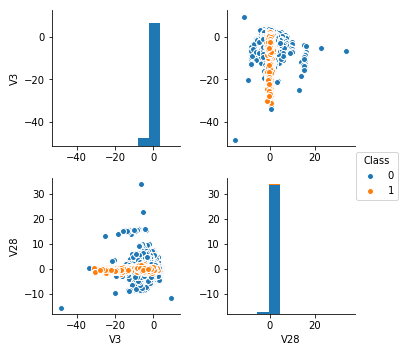

In [72]:
sns.pairplot(datas, vars=["V3", "V28"] , hue="Class")
plt.show()

In [ ]:
y_valid = valid_datas.Class
X_valid = valid_datas.drop(["Class"], axis=1)
display(X_valid.values.shape)

predict = np.ones((X_valid.values.shape[0], 1))

for example in X_valid.values:
    p_x = 1
    for j in range(len(mu)):
        if not j == 0 and not j == 29:
            p_x *= 1 / (math.sqrt(2 * math.pi) * sigma[j]) * math.exp(-(example[j] - mu[j]) / (2 * sigma[j]))
    
example = X_valid.values[100]
p_x = 1
for j in range(len(mu)):
    if not j == 0 and not j == 29:
        print(1 / (math.sqrt(2 * math.pi) * sigma[j]) * math.exp(-(example[j] - mu[j]) / (2 * sigma[j])))
        
display(predict[100])